In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

import autoencoder

print('PyTorch version:', torch.__version__)
print('torchvision version:', torchvision.__version__)
use_gpu = torch.cuda.is_available()
print('Is GPU available:', use_gpu)

PyTorch version: 0.4.1
torchvision version: 0.2.1
Is GPU available: True


In [3]:
# general settings

# device
device = torch.device('cuda' if use_gpu else 'cpu')

# batchsize
batchsize = 64

# seed setting (warning : cuDNN's randomness is remaining)
seed = 1
torch.manual_seed(seed)
if use_gpu:
    torch.cuda.manual_seed(seed)
    
# directory settings
# Data directory (for IR-MNIST)
data_dir = '../../data/IR-MNIST/'
train_data_dir = data_dir + 'Train_Samples/'
test_data_dir = data_dir + 'Test_Samples/'

# directory to put generated images
output_dir = data_dir + 'output/'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
# directory to save state_dict and loss.npy
save_dir = data_dir + 'save/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [4]:
# make dataset class for image loading
class MyDataset(Dataset):
    def __init__(self, root_dir, transform = None):
        self.root_dir = root_dir
        self.list_dir = os.listdir(root_dir)
        self.transform = transform
        
    def __len__(self):
        return len(self.list_dir)
    
    def __getitem__(self, idx):
        img_name = self.root_dir + self.list_dir[idx]
        image = Image.open(img_name)
        
        if self.transform:
            image = self.transform(image)
            
        return image

In [5]:
# define transforms
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# make dataset
trainDataset = MyDataset(train_data_dir, transform = tf)
test_data = MyDataset(test_data_dir, transform = tf)

# split into training data and validation data
train_data, validation_data = train_test_split(trainDataset, test_size = 0.2, random_state = seed)

print('The number of training data:', len(train_data))
print('The number of validation data :', len(validation_data))
print('The number o test data:', len(test_data))

The number of training data: 4000
The number of validation data : 1000
The number o test data: 1050


In [6]:
# make DataLoader
train_loader = DataLoader(train_data, batch_size = batchsize, shuffle = True)
validation_loader = DataLoader(validation_data, batch_size = batchsize, shuffle = True)
test_loader = DataLoader(test_data, batch_size = batchsize, shuffle = True)

In [26]:
feature_extractor = autoencoder.AutoEncoder(8)
params = torch.load(save_dir + 'AE_IR_MNIST_start_8.pth')
feature_extractor.load_state_dict(params)

In [27]:
class Feature_AutoEncoder(nn.Module):
    def __init__(self, n):
        super(Feature_AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
                                autoencoder.Downsampler(   n,  2*n),
                                autoencoder.Downsampler( 2*n,  4*n),
                                autoencoder.Downsampler( 4*n,  8*n),
                                # autoencoder.Downsampler( 8*n, 16*n)
        )
        
        self.decoder = nn.Sequential(
                                # autoencoder.Upsampler( 16*n, 8*n),
                                autoencoder.Upsampler(  8*n, 4*n),
                                autoencoder.Upsampler(  4*n, 2*n),
                                nn.ConvTranspose2d( 2*n, n, kernel_size = 4, stride = 2, padding = 1)
        )
        
    def forward(self, x):
        embed_x = self.encoder(x)
        recon_x = self.decoder(embed_x)
        return recon_x

In [36]:
net = Feature_AutoEncoder(16).to(device)
feature_extractor = feature_extractor.to(device)

optimizer = optim.Adam(net.parameters(), lr = 0.0001, weight_decay = 0.0002)

loss_fn = nn.MSELoss()

num_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print(num_trainable_params)

345040


In [37]:
# the function run training for 1 epoch
def train(train_loader):
    net.train()
    feature_extractor.eval()
    
    running_loss = 0
    
    for inputs in train_loader:
        inputs = inputs.to(device)
        with torch.no_grad():
            feature_maps = feature_extractor.get_feature_map(inputs, 2)
            
        outputs = net(feature_maps)
        
        loss = loss_fn(outputs, feature_maps)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    average_loss = running_loss / len(train_loader)
    
    return average_loss

In [38]:
# the function run validation
def validation(validation_loader):
    net.eval()
    
    running_loss = 0
    
    with torch.no_grad():
        for inputs in train_loader:
            inputs = inputs.to(device)
            feature_maps = feature_extractor.get_feature_map(inputs, 2)
            outputs = net(feature_maps)
            running_loss += loss_fn(outputs, feature_maps).item()
    
    average_loss = running_loss / len(validation_loader)
    
    return average_loss

In [40]:
n_epochs = 80

train_loss_list = []
validation_loss_list = []

overfit = False
former_validation_loss = 1e10

for epoch in range(n_epochs):
    train_loss = train(train_loader)
    validation_loss = validation(validation_loader)
    
    print('epoch[%d/%d] train_loss:%1.7f validation_loss:%1.7f' %(epoch+1, n_epochs, train_loss, validation_loss))
    train_loss_list.append(train_loss)
    validation_loss_list.append(validation_loss)
    
    if former_validation_loss < validation_loss:
        if overfit:
            print('early stopping')
            break
        else:
            overfit = True
    else:
        overfit = False
    
    former_validation_loss = validation_loss
        
torch.save(net.state_dict(), save_dir + 'FeatureAE_IR_MNIST_start_16.pth')

epoch[1/80] train_loss:0.0001608 validation_loss:0.0006365
epoch[2/80] train_loss:0.0001600 validation_loss:0.0006352
epoch[3/80] train_loss:0.0001592 validation_loss:0.0006396
epoch[4/80] train_loss:0.0001590 validation_loss:0.0006377
epoch[5/80] train_loss:0.0001580 validation_loss:0.0006308
epoch[6/80] train_loss:0.0001572 validation_loss:0.0006208
epoch[7/80] train_loss:0.0001568 validation_loss:0.0006409
epoch[8/80] train_loss:0.0001571 validation_loss:0.0006434
early stopping


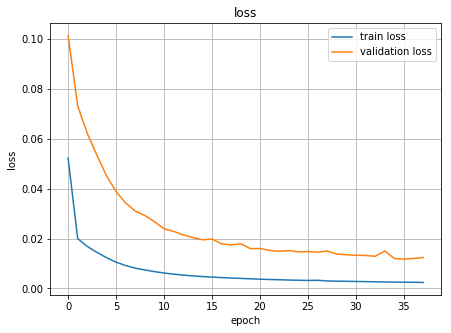

In [53]:
# visualize training log
plt.figure(figsize = (7,5))
plt.plot(train_loss_list, label = 'train loss')
plt.plot(validation_loss_list, label = 'validation loss')
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

In [54]:
normal_data = iter(validation_loader).next().to(device)
abnormal_data = iter(test_loader).next().to(device)

In [59]:
net.eval()
with torch.no_grad():
    normal_feature_maps = feature_extractor.get_feature_map(normal_data, 2)
    abnormal_feature_maps = feature_extractor.get_feature_map(abnormal_data, 2)
    normal_recon_feature_maps = net(normal_feature_maps)
    abnormal_recon_feature_maps = net(abnormal_feature_maps)

In [91]:
class MapTo_image(nn.Module):
    def __init__(self):
        super(MapTo_image, self).__init__()
    
        self.decoder = nn.Sequential(
                                nn.ConvTranspose2d(1, 1, kernel_size = 4, stride = 2, padding = 1),
                                nn.ConvTranspose2d(1, 1, kernel_size = 4, stride = 2, padding = 1)
        )
    
        for layer in self.decoder:
            nn.init.constant_(layer.weight, 1)
            nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        return self.decoder(x)
mapping = MapTo_image()
mapping.to(device)

MapTo_image(
  (decoder): Sequential(
    (0): ConvTranspose2d(1, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [92]:
def show_image(tensor_image):
    np_image = tensor_image.numpy()
    np_image = np.transpose(np_image, [1, 2, 0]) * 0.5 + 0.5
    plt.imshow(np_image)
    
index = 0

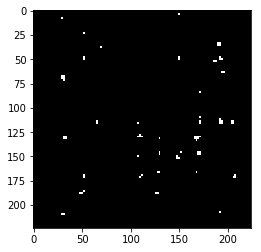

In [102]:
normal_diff = (normal_feature_maps[index] - normal_recon_feature_maps[index]).pow(2).sum(dim = 0)
mapping.eval()
with torch.no_grad():
    normal_diff = mapping(normal_diff.unsqueeze(0).unsqueeze(0))
plt.imshow(normal_diff[0][0] > 0.7, cmap = 'gray')

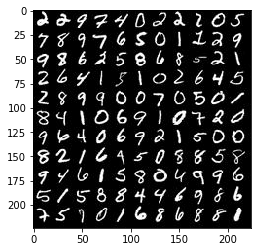

In [94]:
show_image(normal_data[index].cpu())

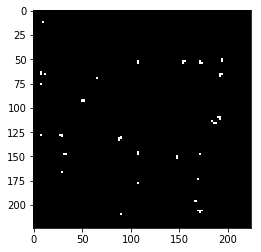

In [101]:
abnormal_diff = (abnormal_feature_maps[index] - abnormal_recon_feature_maps[index]).pow(2).sum(dim = 0)
mapping.eval()
with torch.no_grad():
    abnormal_diff = mapping(abnormal_diff.unsqueeze(0).unsqueeze(0))
plt.imshow(abnormal_diff[0][0] > 0.7, cmap = 'gray')

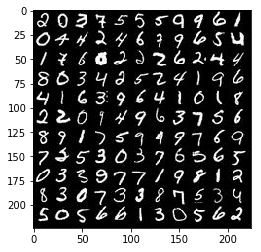

In [96]:
show_image(abnormal_data[index].cpu())